# Lego World Map

Code inspired from Milan Janosov to create a stylized elevation map of the world.

You can read about his work creating a Lego elevation map of Budapest [here](https://open.substack.com/pub/milanjanosov/p/lego-elevation-map?r=3mp6w8&utm_medium=ios) on his Substack.

## Imports

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
import sys
import subprocess
import glob
import string
from osgeo import gdal
from pathlib import Path
import os

DEM Raster data sourced from here:

https://earthexplorer.usgs.gov

We'll be merging the elevation files following the example from Abdishakur:
https://medium.com/spatial-data-science/how-to-mosaic-merge-raster-data-in-python-fb18e44f3c8

## Merge DEMs

In [ ]:
# setup paths
path=Path('../_data/dem_world_gtopo30')
Path('output').mkdir(parents=True,exist_ok=True)
output_path='output/mosaic_output.tif'

In [10]:
# iterate over the available .tif files in the data folder
raster_files=list(path.iterdir())

# create list to hold files in data folder
raster_to_mosaic=[]

In [11]:
# loop through raster files and add them to raster_to_mosaic list
counter=0
for file in raster_files:
    raster=rio.open(file)
    raster_to_mosaic.append(raster)
    counter+=1
    if counter%5==0:
        print(f'Gone through {counter} files')

print('Done!')

Gone through 5 files
Gone through 10 files
Gone through 15 files
Gone through 20 files
Gone through 25 files
Gone through 30 files
Done!


In [12]:
len(raster_to_mosaic)

33

In [ ]:
mosaic,output=merge(raster_to_mosaic)

In [ ]:
# batch the merging process
batch_size=5
batches=[raster_to_mosaic[i:i+batch_size] for i in range(0,len(raster_to_mosaic),batch_size)]

batch_mosaics=[]

for i,batch in enumerate(batches):
    mosaic,out_trans=merge(batch)
    
    # save each batch mosaic in memory and add to list for final merge
    with MemoryFile() as memfile:
        with memfile.open(driver='GTiff',
                          height=mosaic.shape[1],
                          width=mosaic.shape[2],
                          count=1,
                          dtype=mosaic.dtype) as mem_dst:
            mem_dst.write(mosaic,1)
            batch_mosaics.append(mem_dst)  # add memory file object to list

    print(f'Batch {i+1} complete')

# merge all batch mosaics
final_mosaic, final_transform = merge(batch_mosaics)

In [ ]:
# downsampling control
downsample_factor=2  # 2 will reduce both width and height by half

for i,file in enumerate(raster_files):
    with rio.open(file) as dataset:
        # Read with resampling
        data=dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height/downsample_factor),
                int(dataset.width/downsample_factor)
            ),
            resampling=Resampling.average # different methods are available
        )
        
        # update transform for downsampling
        transform=dataset.transform*dataset.transform.scale(
            (dataset.width/data.shape[-1]),
            (dataset.height/data.shape[-2])
        )
        
        # save downsampled raster temporarily
        with MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=data.shape[1],
                width=data.shape[2],
                count=1,
                dtype=data.dtype,
                transform=transform
            ) as mem_dst:
                mem_dst.write(data,1)
                raster_to_mosaic.append(mem_dst)
                
    print(f'Downsampled and added file {i+1}')

In [ ]:
# batch the merging process
batch_size=4
batches=[raster_to_mosaic[i:i+batch_size] for i in range(0,len(raster_to_mosaic),batch_size)]

# directory to store intermediate batch files
Path('intermediate_batches').mkdir(exist_ok=True)
batch_files=[]

for i, batch in enumerate(batches):
    mosaic,out_trans=merge(batch)
    batch_file_path=f'intermediate_batches/batch_{i}.tif'
    
    # save each batch result as a new file on disk
    with rasterio.open(
        batch_file_path,
        'w',
        driver='GTiff',
        height=mosaic.shape[1],
        width=mosaic.shape[2],
        count=1,
        dtype=mosaic.dtype,
        transform=out_trans
    ) as dst:
        dst.write(mosaic,1)
    
    batch_files.append(batch_file_path)
    print(f'Saved batch {i+1} as {batch_file_path}')

# merge saved intermediate files into final mosaic
raster_to_mosaic=[rasterio.open(file) for file in batch_files]
final_mosaic,final_transform=merge(raster_to_mosaic)

In [54]:
!gdal_merge.py -o final_mosaic_output.tif -of GTiff -co COMPRESS=LZW -co BIGTIFF=YES *.tif

Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/osgeo/__init__.py", line 30, in swig_import_helper
    return importlib.import_module(mname)
  File "/Applications/Anaconda/anaconda3/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 666, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 565, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1173, in create_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
ImportError: dlopen(/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/osgeo/_gdal.cpython-39-darwin.so, 0x0002): Lib

In [14]:
raster_to_mosaic

[<open DatasetReader name='../_data/dem_world_gtopo30/gt30w060s60.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30e060s10.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w140s10.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w020n90.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30e100n90.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w020n40.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30e100n40.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30e020n40.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w100n40.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w180n90.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30w180n40.tif' mode='r'>,
 <open DatasetReader name='../_data/dem_world_gtopo30/gt30e060s60.tif' mode='r'>,
 <open DatasetRe

In [18]:
path=Path('../_data/dem_world_gtopo30')
file_list=os.listdir(path)
file_list

['gt30w060s60.tif',
 'gt30e060s10.tif',
 'gt30w140s10.tif',
 'gt30w020n90.tif',
 'gt30e100n90.tif',
 'gt30w020n40.tif',
 'gt30e100n40.tif',
 'gt30e020n40.tif',
 'gt30w100n40.tif',
 'gt30w180n90.tif',
 'gt30w180n40.tif',
 'gt30e060s60.tif',
 'gt30e020n90.tif',
 'gt30w100n90.tif',
 'gt30w060s10.tif',
 'gt30e140s10.tif',
 'gt30w180s60.tif',
 'gt30w140n40.tif',
 'gt30e060n40.tif',
 'gt30w140n90.tif',
 'gt30e060n90.tif',
 'gt30e100s10.tif',
 'gt30w020s10.tif',
 'gt30e120s60.tif',
 'gt30w000s60.tif',
 'gt30w100s10.tif',
 'gt30e020s10.tif',
 'gt30e140n90.tif',
 'gt30w060n90.tif',
 'gt30w120s60.tif',
 'gt30w180s10.tif',
 'gt30e140n40.tif',
 'gt30w060n40.tif']

In [19]:
len(file_list)

33

In [24]:
# from https://gis.stackexchange.com/questions/449569/\
# merging-a-large-number-of-geotiff-files-via-gdal-merge-py

print('Merging the DEMM files...')

# Find all files with a .tif extension
input_files = glob.glob('../_data/dem_tile_world_gtopo30/*.tif')
print(input_files)

Merging the DEMM files...
['../_data/dem_world_gtopo30/gt30w060s60.tif', '../_data/dem_world_gtopo30/gt30e060s10.tif', '../_data/dem_world_gtopo30/gt30w140s10.tif', '../_data/dem_world_gtopo30/gt30w020n90.tif', '../_data/dem_world_gtopo30/gt30e100n90.tif', '../_data/dem_world_gtopo30/gt30w020n40.tif', '../_data/dem_world_gtopo30/gt30e100n40.tif', '../_data/dem_world_gtopo30/gt30e020n40.tif', '../_data/dem_world_gtopo30/gt30w100n40.tif', '../_data/dem_world_gtopo30/gt30w180n90.tif', '../_data/dem_world_gtopo30/gt30w180n40.tif', '../_data/dem_world_gtopo30/gt30e060s60.tif', '../_data/dem_world_gtopo30/gt30e020n90.tif', '../_data/dem_world_gtopo30/gt30w100n90.tif', '../_data/dem_world_gtopo30/gt30w060s10.tif', '../_data/dem_world_gtopo30/gt30e140s10.tif', '../_data/dem_world_gtopo30/gt30w180s60.tif', '../_data/dem_world_gtopo30/gt30w140n40.tif', '../_data/dem_world_gtopo30/gt30e060n40.tif', '../_data/dem_world_gtopo30/gt30w140n90.tif', '../_data/dem_world_gtopo30/gt30e060n90.tif', '../_da

In [25]:
# Define the output file
output_file = "dem_world_gtopo30.tiff"

# Create a dictionary to store the original file names as keys and new short file names as values
original_names = {}

# Create list of characters (numbers and letters) to use for unique file names
characters = string.digits + string.ascii_letters
j = 0
# Rename all the files in the current directory to have unique short names of 2 characters
for i, file in enumerate(input_files):
    new_name = ''.join(characters[i%len(characters)] + characters[i//len(characters)] + ".t")
    # Check if the new name already exists, ignoring the case
    while os.path.exists(new_name) or new_name.lower() in [f.lower() for f in os.listdir()]:
        i += 1
        new_name = ''.join(characters[i%len(characters)] + characters[i//len(characters)] + ".t")
    os.rename(file, new_name)
    original_names[new_name] = file
    input_files[j] = new_name
    j += 1

input_string = " ".join(input_files)

#Build VRT from input files 
vrt_file = "merged.vrt"
gdal.BuildVRT(vrt_file,input_files)

# Translate VRT to TIFF
gdal.Translate(output_file,vrt_file)

# Rename the files back to their original names
for new_name, original_name in original_names.items():
    os.rename(new_name, original_name)

# remove the vrt file
os.remove(vrt_file)

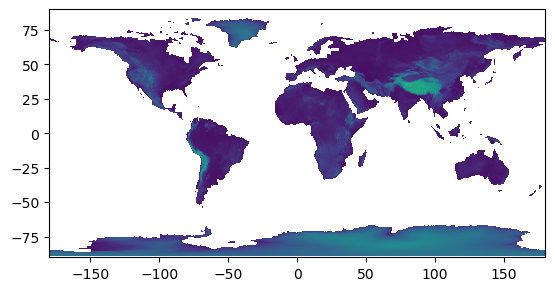

<Axes: >

In [29]:
fp=r'../_data/dem_world_gtopo30.tiff'
img=rio.open(fp)
show(img)

## Old

In [4]:
# import elevation file
gdf=gpd.read_file('../_data/world_elevation_custom.json')

print(len(gdf))
gdf.head()

177


,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,...,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,filename,geometry
0,Admin-0 country,1,5,Costa Rica,CRI,0,2,Sovereign country,1,Costa Rica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRI.geojson,"POLYGON ((-82.54620 9.56613, -82.93289 9.47681..."
1,Admin-0 country,1,5,Nicaragua,NIC,0,2,Sovereign country,1,Nicaragua,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIC.geojson,"POLYGON ((-83.65561 10.93876, -83.89505 10.726..."
2,Admin-0 country,1,5,Haiti,HTI,0,2,Sovereign country,1,Haiti,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HTI.geojson,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."
3,Admin-0 country,1,5,Dominican Republic,DOM,0,2,Sovereign country,1,Dominican Republic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOM.geojson,"POLYGON ((-71.70830 18.04500, -71.68774 18.316..."
4,Admin-0 country,1,6,El Salvador,SLV,0,2,Sovereign country,1,El Salvador,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLV.geojson,"POLYGON ((-89.35333 14.42413, -89.05851 14.340..."


In [7]:
gdf.columns

Index(['featurecla', 'scalerank', 'labelrank', 'sovereignt', 'sov_a3',
       'adm0_dif', 'level', 'type', 'tlc', 'admin',
       ...
       'fclass_id', 'fclass_pl', 'fclass_gr', 'fclass_it', 'fclass_nl',
       'fclass_se', 'fclass_bd', 'fclass_ua', 'filename', 'geometry'],
      dtype='object', length=170)

In [ ]:
gdf['']

KeyError: 'DN'

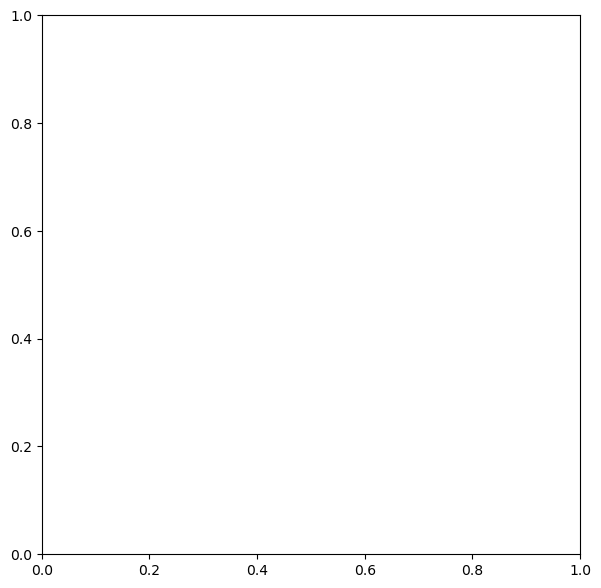

In [6]:
f,ax=plt.subplots(1,1,figsize=(20,7))
gdf.plot(column='e',ax=ax,cmap='terrain')